# Pandas Express
# TTC-Delays project
Team Members:

Gaspare Castagna

Amirhossein Heidari

Avery Hoffer

Michael Metallo

# The purpose of this notebook is generate a prediction model for delay categories based on selected features.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import glob

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

Truncate the analysis files to include only 2022 data.

In [2]:

# Set display options to show all columns without truncation
pd.set_option('display.max_columns', None)

# Assuming your CSV files are in the same directory as your script
files = glob.glob('analysis_data_*.csv')

# Initialize an empty list to store DataFrames
dfs = []

# Iterate through each file
for file in files:
    # Read the CSV file with low_memory=False option
    df = pd.read_csv(file, low_memory=False)
    
    # Filter rows where UTC_YEAR is 2022
    df_2022 = df[df['LOCAL_YEAR'] == 2022]
    
    # Append the filtered data to the list
    dfs.append(df_2022)

# Concatenate all DataFrames in the list
combined_data = pd.concat(dfs, ignore_index=True)

# Now, combined_data contains rows from all CSV files where UTC_YEAR is 2022
#Keep in mind that using low_memory=False might increase memory usage, and it's 

In [3]:
combined_data.head()

,Route,Day,Location,Incident,Min Delay,Min Gap,Vehicle,DateTime,analysis,temp,Unnamed: 0,LOCAL_HOUR,WIND_DIRECTION,WINDCHILL,PRECIP_AMOUNT,HUMIDEX,RELATIVE_HUMIDITY,LOCAL_YEAR,TEMP_FLAG,UTC_MONTH,UTC_DAY,LOCAL_DATE,STATION_PRESSURE,TEMP,UTC_YEAR,WIND_SPEED,LOCAL_DAY,DEW_POINT_TEMP,LOCAL_MONTH,UTC_DATE,VISIBILITY,weather
0,952,Tuesday,TERNMINAL 1,Operations - Operator,9.0,0.0,0.0,2022-01-04 06:02:00,ternminal1,2022-01-04 06:00:00,25579,6,27.0,-11.0,0.0,NaN,73.0,2022,NaN,1,4,2022-01-04 06:00:00,101.48,-4.2,2022,21.0,4,-8.3,1,2022-01-04T11:00:00,16.1,snow
1,953,Tuesday,MORNINGVIEW AND FINCH,Operations - Operator,14.0,28.0,0.0,2022-01-04 05:43:00,Morningview Trail at Old Finch Ave South Side,2022-01-04 06:00:00,25579,6,27.0,-11.0,0.0,NaN,73.0,2022,NaN,1,4,2022-01-04 06:00:00,101.48,-4.2,2022,21.0,4,-8.3,1,2022-01-04T11:00:00,16.1,snow
2,39,Tuesday,OLD FINCH AND LITTLES,Operations - Operator,10.0,25.0,0.0,2022-01-04 06:00:00,Finch Ave West at Goldfinch Crt East Side,2022-01-04 06:00:00,25579,6,27.0,-11.0,0.0,NaN,73.0,2022,NaN,1,4,2022-01-04 06:00:00,101.48,-4.2,2022,21.0,4,-8.3,1,2022-01-04T11:00:00,16.1,snow
3,97,Tuesday,QUEEN'S WUAY AND YONGE,Operations - Operator,15.0,15.0,8132.0,2022-01-04 05:32:00,The Queensway at Roncesvalles Ave,2022-01-04 06:00:00,25579,6,27.0,-11.0,0.0,NaN,73.0,2022,NaN,1,4,2022-01-04 06:00:00,101.48,-4.2,2022,21.0,4,-8.3,1,2022-01-04T11:00:00,16.1,snow
4,60,Tuesday,PIONEER VILLAGE STATIO,Operations - Operator,15.0,30.0,8171.0,2022-01-04 05:44:00,pioneervillagestatio,2022-01-04 06:00:00,25579,6,27.0,-11.0,0.0,NaN,73.0,2022,NaN,1,4,2022-01-04 06:00:00,101.48,-4.2,2022,21.0,4,-8.3,1,2022-01-04T11:00:00,16.1,snow


# Additional Feature Creation 
Create additional feature categories for weather and holiday. These categories provide basic information on weather conditions and whether or not a date is a statuatoy holiday. 

In [4]:
# Define the conditions and corresponding values for the 'weather' column
conditions = [
    (combined_data['TEMP'] >= 0) & (combined_data['PRECIP_AMOUNT'] > 0),
    (combined_data['TEMP'] < 0) & (combined_data['PRECIP_AMOUNT'] > 0),
    (combined_data['PRECIP_AMOUNT'] == 0),
    (combined_data['TEMP'].isna()) | (combined_data['PRECIP_AMOUNT'].isna())
]

values = ['rain', 'snow', 'dry', 'unknown']

# Use numpy's select function to apply the conditions and update the 'weather' column
combined_data['weather'] = np.select(conditions, values, default=combined_data['weather'])

In [5]:
# Convert 'LOCAL_DATE' column to datetime type
combined_data['LOCAL_DATE'] = pd.to_datetime(combined_data['LOCAL_DATE'])

# Define a function to check if a date is a holiday
def is_holiday(date):
    holidays = [
        '2022-01-01', '2022-02-21', '2022-04-15', '2022-04-18',
        '2022-05-23', '2022-07-01', '2022-08-01', '2022-09-05',
        '2022-10-10', '2022-11-11', '2022-12-25', '2022-12-26'
    ]
    return 1 if date.strftime('%Y-%m-%d') in holidays else 0

# Create a new column 'is_holiday'
combined_data['HOLIDAY'] = combined_data['LOCAL_DATE'].apply(is_holiday)

# Feature Encoding
Create a function that encodes a giving feature. Each unique value is assigned a corresponding unique integer. This encoding will alow RandomForest to properly create a model.

In [6]:
from sklearn.preprocessing import LabelEncoder
def encode_column_to_numbers(dataframe, column_name):
    """
    Encode a column in a DataFrame to a single set of integer values.

    Parameters:
    - dataframe: pandas DataFrame
    - column_name: str, the name of the column to be encoded

    Returns:
    - dataframe: pandas DataFrame, the input DataFrame with an additional column containing encoded values
    """
    # Make a copy of the DataFrame to avoid modifying the original
    df = dataframe.copy()

    # Convert all values in the specified column to strings
    df[column_name] = df[column_name].astype(str)

    # Create a LabelEncoder instance
    label_encoder = LabelEncoder()

    # Fit and transform the specified column to integer labels
    df[f'{column_name}_Encoded'] = label_encoder.fit_transform(df[column_name])

    # Display the mapping of original values to encoded integers
    mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    # Return the DataFrame, encoded column, and mapping
    return df[f'{column_name}_Encoded']

The delays, what are being predicted, will be categorized into short, medium, long, and crippling delays. This categorization is to create a more valuable model than simply providing the expected delay time.

In [7]:
# Create category for the delays
# Define the bin edges for delay categories
bins = [-float('inf'), 5, 15, 30, 90, float('inf')]

# Define the corresponding labels for each category
labels = ['Short Delays', 'Medium Delays', 'Long Delays', 'Crippling Delays', 'Outliers']

# Create a new column 'Delay Category' based on the delay times
combined_data['Delay_Category'] = pd.cut(combined_data['Min Delay'], bins=bins, labels=labels, right=False)
#Drop Dataframe rows with Outliers
combined_data = combined_data[combined_data.ne('Outliers').all(axis=1)]
# Encode Delay Category
combined_data['DELAY_CATEGORY'] = encode_column_to_numbers(combined_data, 'Delay_Category')

In [8]:
# Print column headers to view all potential feature categories
print(combined_data.columns)
# Write the DataFrame to a CSV file to view all information
# Specify the file path where you want to save the CSV file
file_path = '2022_Random_Forest_Data.csv'
combined_data.to_csv(file_path, index=False)

Index(['Route', 'Day', 'Location', 'Incident', 'Min Delay', 'Min Gap',
       'Vehicle', 'DateTime', 'analysis', 'temp', 'Unnamed: 0', 'LOCAL_HOUR',
       'WIND_DIRECTION', 'WINDCHILL', 'PRECIP_AMOUNT', 'HUMIDEX',
       'RELATIVE_HUMIDITY', 'LOCAL_YEAR', 'TEMP_FLAG', 'UTC_MONTH', 'UTC_DAY',
       'LOCAL_DATE', 'STATION_PRESSURE', 'TEMP', 'UTC_YEAR', 'WIND_SPEED',
       'LOCAL_DAY', 'DEW_POINT_TEMP', 'LOCAL_MONTH', 'UTC_DATE', 'VISIBILITY',
       'weather', 'HOLIDAY', 'Delay_Category', 'DELAY_CATEGORY'],
      dtype='object')


Visual showing the encoding process.

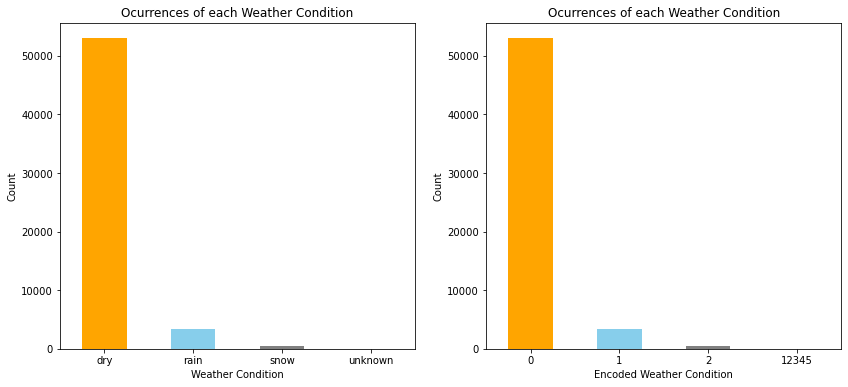

In [9]:
# Choose the column you want to visualize
column_name = 'weather'

# Get the counts of unique values in the specified column
value_counts = combined_data[column_name].value_counts()

# Assign different colors to each bar
colors = ['orange', 'skyblue', 'gray', 'red']
# Create a bar chart with different colors
plt.figure(figsize=(14, 6))
# Original graph
plt.subplot(1, 2, 1)
value_counts.plot(kind='bar', color=colors)
plt.xlabel('Weather Condition')
plt.ylabel('Count')
plt.title('Ocurrences of each Weather Condition')
plt.xticks(rotation='horizontal')
# Second graph with custom x-axis labels
plt.subplot(1, 2, 2)
value_counts.plot(kind='bar', color=colors)
plt.xlabel('Encoded Weather Condition')
plt.ylabel('Count')
plt.title('Ocurrences of each Weather Condition')
plt.xticks([0, 1, 2, 3], [0, 1, 2, 12345],rotation='horizontal')  # Set custom x-axis ticks and labels

plt.show()

# Initial Feature Selection
Initial features were selected. Every applicable feature was used to generate the initial model (besides duplicate features such as UTC_HOUR and LOCAL_HOUR). Day, Incident, weather, Route, Location, and Vehicle were encoded using the encoding function above.

In [10]:
def feature_engineering(data):
    '''Return features based on data 
    '''
    data_copy=data.copy()
    # Map Days,Incidents, Weather, Route, Location, and Vehicle
    
    data_copy['WEEKDAY'] = encode_column_to_numbers(data_copy, 'Day')
    data_copy['INCIDENT_TYPE'] = encode_column_to_numbers(data_copy, 'Incident')
    data_copy['WEATHER'] = encode_column_to_numbers(data_copy, 'weather')
    data_copy['ROUTE'] = encode_column_to_numbers(data_copy, 'Route')
    data_copy['LOCATION'] = encode_column_to_numbers(data_copy, 'Location')
    data_copy['VEHICLE'] = encode_column_to_numbers(data_copy, 'Vehicle')
    feature_selected= ['ROUTE','VEHICLE','LOCATION','INCIDENT_TYPE','STATION_PRESSURE','TEMP','DEW_POINT_TEMP',
                       'LOCAL_HOUR','RELATIVE_HUMIDITY','WIND_SPEED', 'WIND_DIRECTION','WEEKDAY','LOCAL_MONTH',
                       'WINDCHILL','HUMIDEX','VISIBILITY','PRECIP_AMOUNT','WEATHER','HOLIDAY']
    # Assign to new DF
    data_copy = data_copy[feature_selected]
    # Impute missing values (for example, filling with the mean)
    data_copy = data_copy.fillna(12345)
    return data_copy[feature_selected]

X = feature_engineering(combined_data)
#Create a separate X2 for the correlation matrix at the end
X2 = X
# Labels
y = combined_data["DELAY_CATEGORY"]

# Split into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)
# Print the shape of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_val.shape}")

X_train shape: (45463, 19)
X_test shape: (11366, 19)
y_train shape: (45463,)
y_test shape: (11366,)


Visual of the missing data in each feature. 

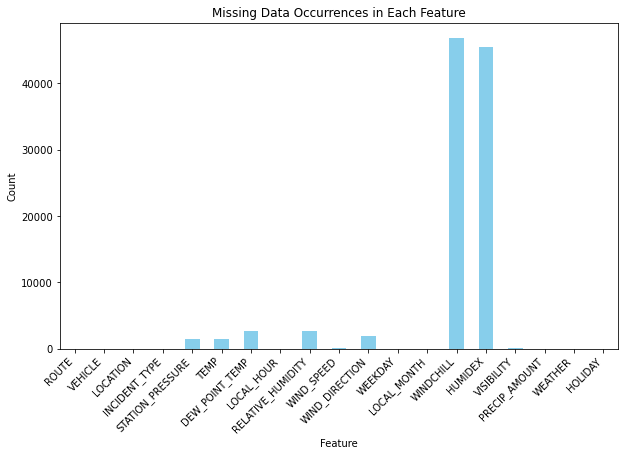

In [11]:
# Count the occurrences of 12345 in each column
count_12345_per_column = (X == 12345).sum()

# Create a bar chart
plt.figure(figsize=(10, 6))
count_12345_per_column.plot(kind='bar', color='skyblue')
plt.title('Missing Data Occurrences in Each Feature')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

# Model Creation
A RandomForestClassifier model was used and F1 score was determined, as well as other metrics such as precision, recall, and false alarm rate.

In [12]:
# Instantiate a classifier model
model = RandomForestClassifier()

In [13]:
# Fit and predict
model.fit(X_train, y_train)

RandomForestClassifier()

In [14]:
y_pred = model.predict(X_val)

In [15]:
print(f1_score(y_val, y_pred, average='weighted'))

0.6792455600343938


In [16]:
# Calculate precision, recall, and false alarm rate
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# False Alarm Rate (FAR) = 1 - Precision
far = 1 - precision

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("False Alarm Rate:", far)

Precision: 0.6894146289533251
Recall: 0.7015660742565546
F1 Score: 0.6792455600343938
False Alarm Rate: 0.31058537104667494


# Feature Importance
Visual showing the importance of each feature in contribution to the initial model.

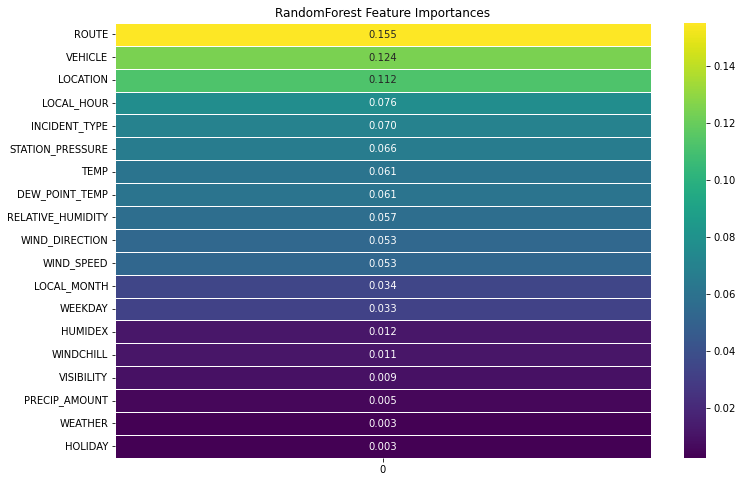

In [17]:
# Get feature importances from the trained model
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
# Sort feature importances in descending order
feature_importances = feature_importances.sort_values(ascending=False)

# Create a heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(feature_importances), annot=True, cmap='viridis', fmt='.3f', linewidths=.5)
plt.title('RandomForest Feature Importances')
plt.show()

# Revised Feature Selection & Model Creation
Low correlation (PRECIP_AMOUNT, WEATHER, and HOLIDAY) features were removed. Features STATION_PRESSURE, DEW_POINT_TEMP, and RELATIVE_HUMIDITY were assumed to be represented in the TEMP feature. Features of WIND_DIRECTION, WINDCHILL, HUMIDEX, and WIND_SPEED were assumed to be not important.

In [18]:
def feature_engineering(data):
    '''Return features based on data 
    '''
    data_copy=data.copy()
    # Map Days,Incidents, Weather, Route, Location, and Vehicle
    
    data_copy['WEEKDAY'] = encode_column_to_numbers(data_copy, 'Day')
    data_copy['INCIDENT_TYPE'] = encode_column_to_numbers(data_copy, 'Incident')
    data_copy['WEATHER'] = encode_column_to_numbers(data_copy, 'weather')
    data_copy['ROUTE'] = encode_column_to_numbers(data_copy, 'Route')
    data_copy['LOCATION'] = encode_column_to_numbers(data_copy, 'Location')
    data_copy['VEHICLE'] = encode_column_to_numbers(data_copy, 'Vehicle')
    feature_selected= ['ROUTE','VEHICLE','LOCATION','INCIDENT_TYPE','TEMP',
                       'LOCAL_HOUR','WEEKDAY','LOCAL_MONTH','VISIBILITY']
    # Assign to new DF
    data_copy = data_copy[feature_selected]
    # Impute missing values (for example, filling with the mean)
    data_copy = data_copy.fillna(12345)
    return data_copy[feature_selected]

#df_10000=combined_data.sample(n=10000, random_state=42)

X = feature_engineering(combined_data)

# Labels
y = combined_data["DELAY_CATEGORY"]

# Split into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)


# Instantiate a classifier model
model = RandomForestClassifier()
# Fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f1_score(y_val, y_pred, average='weighted'))
# ['ROUTE,'VEHICLE','LOCATION',INCIDENT_TYPE','STATION_PRESSURE','TEMP','DEW_POINT_TEMP','LOCAL_HOUR','RELATIVE_HUMIDITY','WIND_SPEED',
#       'WIND_DIRECTION','WEEKDAY','LOCAL_MONTH','WINDCHILL','HUMIDEX','VISIBILITY','PRECIP_AMOUNT','WEATHER','HOLIDAY']

0.7353182248474197


Verify feature selection by ensuring removing any of the selected features decreases F1 score. Dictionary with the corresponding F1 change for each feature below.

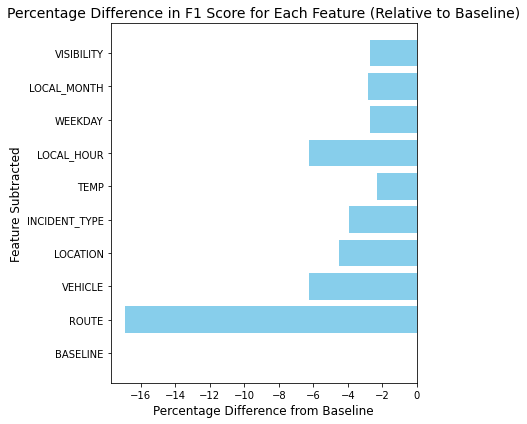

In [19]:
# Remove selected features indivdually and record f1 score
subtract={'BASELINE':0.734,'ROUTE':0.610,'VEHICLE':0.688,'LOCATION':0.701,'INCIDENT_TYPE':0.705,'TEMP':0.717,
          'LOCAL_HOUR':0.688,'WEEKDAY':0.714,'LOCAL_MONTH':0.713,'VISIBILITY':0.714}
# Extract keys and values from the dictionary
features = list(subtract.keys())
baseline_f1 = subtract['BASELINE']  # Baseline F1 score
f1_scores = list(subtract.values())

# Calculate the percentage difference relative to the baseline
percentage_difference = [(f1 - baseline_f1) / baseline_f1 * 100 for f1 in f1_scores]

# Create a bar chart with rotated x-axis labels
plt.figure(figsize=(6, 6))
bars = plt.barh(features, percentage_difference, color='skyblue')  # Swap x and y
plt.ylabel('Feature Subtracted', fontsize=12)
plt.xlabel('Percentage Difference from Baseline', fontsize=12)
plt.title('Percentage Difference in F1 Score for Each Feature (Relative to Baseline)', fontsize=14)

plt.tight_layout()
plt.show()

Verify feature selection by ensuring adding any of the removed features decreases F1 score. Dictionary with the corresponding F1 change for each feature below.

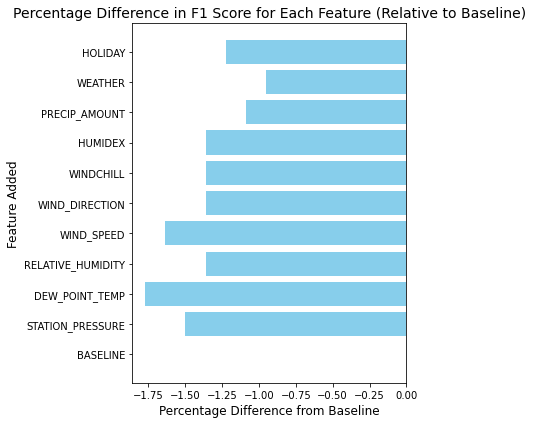

In [20]:
# Add removed features indivdually and record f1 score
add={'BASELINE':0.734,'STATION_PRESSURE':0.723,'DEW_POINT_TEMP':0.721,'RELATIVE_HUMIDITY':0.724,'WIND_SPEED':0.722,'WIND_DIRECTION':0.724,
    'WINDCHILL':0.724,'HUMIDEX':0.724,'PRECIP_AMOUNT':0.726,'WEATHER':0.727,'HOLIDAY':0.725}

# Extract keys and values from the dictionary
entries = list(add.keys())
values = list(add.values())

# Calculate the percentage difference relative to the baseline
baseline_value = values[0]
percentage_difference = [(value - baseline_value) / baseline_value * 100 for value in values]

# Create a bar chart with rotated x-axis labels
plt.figure(figsize=(6, 6))
bars = plt.barh(entries, percentage_difference, color='skyblue')  # Swap x and y
plt.ylabel('Feature Added', fontsize=12)
plt.xlabel('Percentage Difference from Baseline', fontsize=12)
plt.title('Percentage Difference in F1 Score for Each Feature (Relative to Baseline)', fontsize=14)

plt.tight_layout()
plt.show()

# Hyperparameter Optimization
Optimize for hyperparameters.

In [21]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Modify model based on changing hyperparametrs from the baseline values. The optimal hyperparameters were kept in the RandomForestClassifier function below. 

In [22]:
# modify model hyperparameters to achieve a better f1 score
model = RandomForestClassifier(n_estimators=500,bootstrap=False)
# Fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f1_score(y_val, y_pred, average='weighted'))

0.7376446535610928


Dictionary with the corresponding F1 change for each hyperparameter modification below (baseline value in [ ]).

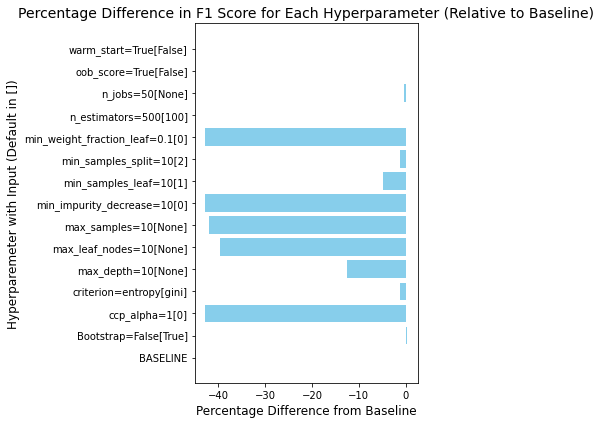

In [23]:
# Hyperparemeters dictionary with values
hyperparameters={'BASELINE':0.734,'Bootstrap=False[True]':0.737,'ccp_alpha=1[0]':0.419,'criterion=entropy[gini]':0.726,'max_depth=10[None]':0.642,
               'max_leaf_nodes=10[None]':0.443,'max_samples=10[None]':0.425,'min_impurity_decrease=10[0]':0.419,'min_samples_leaf=10[1]':0.698,
                'min_samples_split=10[2]':0.726,'min_weight_fraction_leaf=0.1[0]':0.419,'n_estimators=500[100]':0.735,'n_jobs=50[None]':0.731,
                'oob_score=True[False]':0.734,'warm_start=True[False]':0.734}
# Extract keys and values from the dictionary
features = list(hyperparameters.keys())
baseline_f1 = hyperparameters['BASELINE']  # Baseline F1 score
f1_scores = list(hyperparameters.values())

# Calculate the percentage difference relative to the baseline
percentage_difference = [(f1 - baseline_f1) / baseline_f1 * 100 for f1 in f1_scores]

# Create a bar chart with rotated x-axis labels
plt.figure(figsize=(6, 6))
bars = plt.barh(features, percentage_difference, color='skyblue')  # Swap x and y
plt.ylabel('Hyperparemeter with Input (Default in [])', fontsize=12)
plt.xlabel('Percentage Difference from Baseline', fontsize=12)
plt.title('Percentage Difference in F1 Score for Each Hyperparameter (Relative to Baseline)', fontsize=14)
plt.tight_layout()
plt.show()

# Model Validation
Ensure model is valid using 5-fold cross validation.

In [ ]:
# Define the number of folds for cross-validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the F1 score as the evaluation metric
f1_scorer = make_scorer(f1_score, average='weighted')  

# Perform cross-validation and calculate F1 scores
f1_scores = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=f1_scorer)

# Calculate the standard deviation of F1 scores
std_dev = np.std(f1_scores)

# Calculate the maximum margin of error (95% confidence interval)
margin_of_error = 1.96 * std_dev  # For a 95% confidence interval

# Print the F1 scores for each fold
print("F1 Scores for each fold:", f1_scores)

# Print the average F1 score
print("Average F1 Score:", f1_scores.mean())

# Print the maximum margin of error
print("Maximum Margin of Error:", margin_of_error)

Final model precision, recall, F1 score, and false alarm rate.

In [ ]:
# Calculate precision, recall, and false alarm rate
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# False Alarm Rate (FAR) = 1 - Precision
far = 1 - precision

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("False Alarm Rate:", far)

Final model feature importance heatmap.

In [ ]:
# Get feature importances from the trained model
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
# Sort feature importances in descending order
feature_importances = feature_importances.sort_values(ascending=False)

# Create a heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(feature_importances), annot=True, cmap='viridis', fmt='.3f', linewidths=.5)
plt.title('RandomForest Feature Importances')
plt.show()

Create feature correlation matrix for the initial and final model. Features that were highly correlated (ex: TEMP and DEW_POINT_TEMP) were removed so only one feature remained (ex: only TEMP was kept).

In [ ]:
# Calculate correlation matrices
correlation_matrix1 = X2.corr()
correlation_matrix2 = X.corr()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the first correlation matrix without numbers
sns.heatmap(correlation_matrix1, annot=False, cmap='viridis', linewidths=.5, ax=axes[0])
axes[0].set_title('Correlation Matrix for Initial Model')

# Plot the second correlation matrix without numbers
sns.heatmap(correlation_matrix2, annot=False, cmap='viridis', linewidths=.5, ax=axes[1])
axes[1].set_title('Correlation Matrix for Final Model')

plt.tight_layout()
plt.show()